In [95]:
import re
import sys
import os
from tempfile import TemporaryDirectory
import numpy as np
import pandas as pd 

from collections import defaultdict
import tensorflow as tf
tf.get_logger().setLevel('ERROR') # only show error messages

from recommenders.utils.timer import Timer
from recommenders.datasets.amazon_reviews import get_review_data
from recommenders.datasets.split_utils import filter_k_core

# Transformer Based Models
from recommenders.models.sasrec.model import SASREC
from recommenders.models.sasrec.ssept import SSEPT

# Sampler for sequential prediction
from recommenders.models.sasrec.sampler import WarpSampler
from recommenders.models.sasrec.util import SASRecDataSet

import matplotlib.pyplot as plt

print("System version: {}".format(sys.version))
print("Tensorflow version: {}".format(tf.__version__))

System version: 3.9.15 | packaged by conda-forge | (main, Nov 22 2022, 08:48:25) 
[Clang 14.0.6 ]
Tensorflow version: 2.11.0


In [96]:
num_epochs = 5
batch_size = 128
RANDOM_SEED = 100  # Set None for non-deterministic result

lr = 0.001             # learning rate
maxlen = 50            # maximum sequence length for each user
num_blocks = 2         # number of transformer blocks
hidden_units = 100     # number of units in the attention calculation
num_heads = 1          # number of attention heads
dropout_rate = 0.1     # dropout rate
l2_emb = 0.0           # L2 regularization coefficient
num_neg_test = 100     # number of negative examples per positive example
model_name = 'sasrec'  # 'sasrec' or 'ssept'

In [97]:
dataset_name = 'sas'

In [98]:
# read raw data
train = pd.read_csv('../data/{}/train.csv'.format(dataset_name))
test  = pd.read_csv('../data/{}/test.csv'.format(dataset_name))

In [99]:
# sort by time, save the temporary version
train = train.sort_values(['userID', 'timestamp'])
test = test.sort_values(['userID', 'timestamp'])

train[['userID', 'itemID']].to_csv('../data/{}/train_tmp.csv'.format(dataset_name), index=False, header=False)
test[['userID', 'itemID']].to_csv('../data/{}/test_tmp.csv'.format(dataset_name), index=False, header=False)

<h1>Custom data feeder</h1>

In [100]:
# initiate a dataset class 
data = SASRecDataSet(filename='../data/{}/train_tmp.csv'.format(dataset_name), col_sep=",")

In [101]:
# custom split from train / test / validation
from collections import defaultdict
def data_partition(self, filename_train, filename_test):
    # assume user/item index starting from 1
    f = open(filename_train, "r")
    for line in f:
        u, i = line.rstrip().split(self.col_sep)
        u = int(u)
        i = int(i)
        self.usernum = max(u, self.usernum)
        self.itemnum = max(i, self.itemnum)
        self.User[u].append(i)

    for user in self.User:
        nfeedback = len(self.User[user])
        if nfeedback < 2:
            self.user_train[user] = self.User[user]
            self.user_valid[user] = []
            self.user_test[user] = []
        else:
            self.user_train[user] = self.User[user][:-1]
            self.user_valid[user] = []
            self.user_valid[user].append(self.User[user][-1])
            self.user_test[user] = []

    User_test = defaultdict(list)
    f = open(filename_test, "r")
    for line in f:
        u, i = line.rstrip().split(self.col_sep)
        u = int(u)
        i = int(i)
        User_test[u].append(i)

    for user in User_test:
        self.user_test[user] = User_test[user][:]

data_partition(data, '../data/{}/train_tmp.csv'.format(dataset_name), '../data/{}/test_tmp.csv'.format(dataset_name))

<h1>Model definition</h1>

In [102]:
model = SASREC(item_num=data.itemnum,
    seq_max_len=maxlen,
    num_blocks=num_blocks,
    embedding_dim=hidden_units,
    attention_dim=hidden_units,
    attention_num_heads=num_heads,
    dropout_rate=dropout_rate,
    conv_dims = [100, 100],
    l2_reg=l2_emb,
    num_neg_test=data.itemnum-1#num_neg_test
)

In [103]:
sampler = WarpSampler(data.user_train, data.usernum, data.itemnum, batch_size=batch_size, maxlen=maxlen, n_workers=8)

In [104]:
with Timer() as train_time:
    t_test = model.train(data, sampler, num_epochs=4, batch_size=batch_size, lr=lr, val_epoch=6)

print('Time cost for training is {0:.2f} mins'.format(train_time.interval/60.0))


epoch: 4, test (NDCG@10: 0.18711227640915432, HR@10: 0.29391810031499876)
Time cost for training is 2.67 mins


In [107]:
import random
from tqdm import tqdm

def predict(self, dataset):
    usernum = dataset.usernum
    itemnum = dataset.itemnum
    train = dataset.user_train
    valid = dataset.user_valid
    test = dataset.user_test

    if usernum > 10000:
        users = random.sample(range(1, usernum + 1), 10000)
    else:
        users = range(1, usernum + 1)

    results = {}
    for u in tqdm(users, ncols=70, leave=False, unit="b"):
        # not enought training data
        if len(train[u]) < 1 or len(test[u]) < 1:
            continue

        # construct user purchase history
        seq = np.zeros([self.seq_max_len], dtype=np.int32)
        idx = self.seq_max_len - 1
        seq[idx] = valid[u][0]
        idx -= 1
        for i in reversed(train[u]):
            seq[idx] = i
            idx -= 1
            if idx == -1:
                break

            # already interacted items
            rated = set(train[u])

            item_idx = np.arange(itemnum)

            inputs = {}
            inputs["user"] = np.expand_dims(np.array([u]), axis=-1)
            inputs["input_seq"] = np.array([seq])
            inputs["candidate"] = np.array([item_idx])

            # inverse to get descending sort
            predictions = -1.0 * self.predict(inputs)
            predictions = np.array(predictions)
            predictions = predictions[0]

            results[u] = {'predictions': predictions, 'test': test[u]}

    return results

In [108]:
pred = predict(model, data)

In [109]:
TOP_K = 500

items_predicted = []
score_predicted = []
user_ids = []

for u,v in pred.items():
    
    i_pred = v['predictions'].argsort()[:TOP_K]
    s_pred = -1 * v['predictions'][i_pred]

    items_predicted.extend(list(i_pred))
    score_predicted.extend(list(s_pred))
    user_ids.extend(list(np.full(TOP_K, u)))

df_pred = pd.DataFrame({'userID': user_ids, 'itemID': items_predicted, 'prediction': score_predicted})
df_pred.shape

(2089500, 3)

In [110]:
df_pred.head()

,userID,itemID,prediction
0,5439,2089,5.446735
1,5439,181,3.110389
2,5439,214,2.796380
3,5439,1836,2.437398
4,5439,1539,2.060327


In [111]:
user_ids = []
test_ids = []
for u,v in pred.items():
    test_ids.extend(list(v['test']))
    user_ids.extend(list(np.full(len(v['test']), u)))

df_test = pd.DataFrame({'userID': user_ids, 'itemID': test_ids})
df_test['rating'] = 1.0
df_test.shape

(9430, 3)

In [112]:
df_test.head()

,userID,itemID,rating
0,5439,2089,1.0
1,28057,1523,1.0
2,28057,151,1.0
3,8922,1268,1.0
4,411,568,1.0


In [113]:
# from predicted dataset exclude seen items
merged = pd.merge(train, df_pred, on=["userID", "itemID"], how="outer")
merged_pred = merged[merged.rating.isnull()].drop('rating', axis=1)

In [114]:
# from ground truth test dataset, exclude seen items
merged = pd.merge(train, df_test, on=["userID", "itemID"], how="outer")
merged_test = merged[merged.rating_x.isnull()].drop('rating_x', axis=1).rename(columns={'rating_y': 'rating'})

In [115]:
from recommenders.evaluation.python_evaluation import map_at_k, ndcg_at_k, precision_at_k, recall_at_k

In [122]:
TOP_K = 5
eval_map = map_at_k(df_test, df_pred, col_prediction='prediction', k=TOP_K)
eval_ndcg = ndcg_at_k(df_test, df_pred, col_prediction='prediction', k=TOP_K)
eval_precision = precision_at_k(df_test, df_pred, col_prediction='prediction', k=TOP_K)
eval_recall = recall_at_k(df_test, df_pred, col_prediction='prediction', k=TOP_K)

print("K:\t%f" % TOP_K,
      "MAP:\t%f" % eval_map,
      "NDCG:\t%f" % eval_ndcg,
      "Precision@K:\t%f" % eval_precision,
      "Recall@K:\t%f" % eval_recall, sep='\n')

K:	5.000000
MAP:	0.101536
NDCG:	0.135312
Precision@K:	0.060637
Recall@K:	0.163315


In [123]:
eval_map = map_at_k(merged_test, merged_pred, col_prediction='prediction', k=TOP_K)
eval_ndcg = ndcg_at_k(merged_test, merged_pred, col_prediction='prediction', k=TOP_K)
eval_precision = precision_at_k(merged_test, merged_pred, col_prediction='prediction', k=TOP_K)
eval_recall = recall_at_k(merged_test, merged_pred, col_prediction='prediction', k=TOP_K)

print("K:\t%f" % TOP_K,
      "MAP:\t%f" % eval_map,
      "NDCG:\t%f" % eval_ndcg,
      "Precision@K:\t%f" % eval_precision,
      "Recall@K:\t%f" % eval_recall, sep='\n')

K:	5.000000
MAP:	0.064450
NDCG:	0.087822
Precision@K:	0.041683
Recall@K:	0.111269


<h3>SAS RFM</h3>

In [124]:
rfm = pd.read_parquet('../data/sas/mart/rfm_mapped.parquet')
rfm_levels = ["Can't Loose Them", "Champions", "Loyal", "Potential", "Sleeping", "Require Activation"]

In [126]:
TOP_K = 10
NDCGs = []
for level in rfm_levels:
    users = rfm[rfm['RFM_Level'] == level]['phone'].unique()

    m_test_s = merged_test[merged_test['userID'].isin(users)]
    m_pred_s = merged_pred[merged_pred['userID'].isin(users)]

    print(m_test_s.shape, m_pred_s.shape)

    eval_map = map_at_k(m_test_s, m_pred_s, col_prediction='prediction', k=TOP_K)
    eval_ndcg = ndcg_at_k(m_test_s, m_pred_s, col_prediction='prediction', k=TOP_K)

    NDCGs.append(eval_ndcg)

(840, 4) (205878, 4)
(579, 4) (159698, 4)
(683, 4) (215365, 4)
(740, 4) (259560, 4)
(427, 4) (172222, 4)
(82, 4) (36721, 4)


In [130]:
for level, ndcg in zip(rfm_levels, NDCGs):
    print(level, np.round(ndcg, 4))

Can't Loose Them 0.0614
Champions 0.0694
Loyal 0.1131
Potential 0.1093
Sleeping 0.1088
Require Activation 0.1175


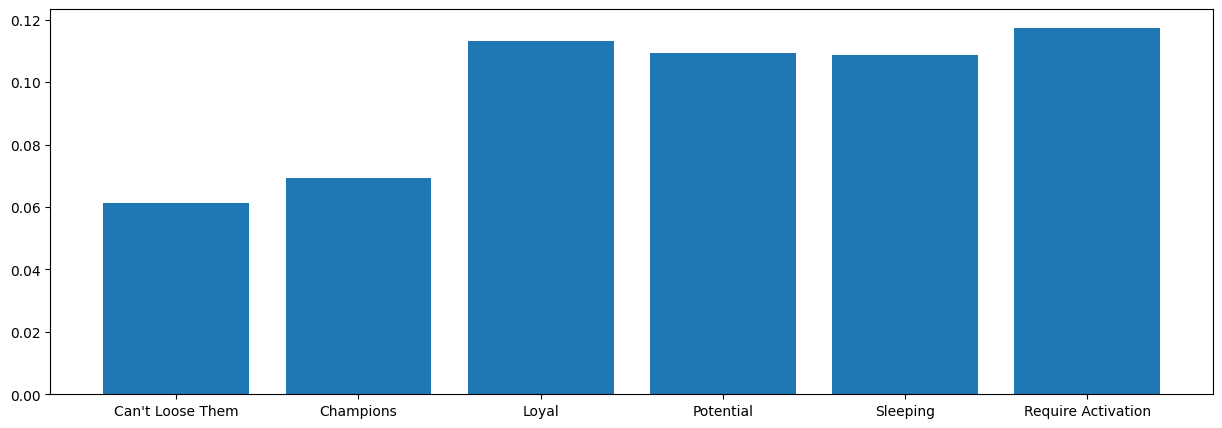

In [127]:
plt.figure(figsize=(15,5))
plt.bar(rfm_levels, NDCGs);

In [68]:
import random
from tqdm import tqdm

def evaluate(self, dataset):
    """
    Evaluation on the test users (users with at least 3 items)
    """
    usernum = dataset.usernum
    itemnum = dataset.itemnum
    train = dataset.user_train
    valid = dataset.user_valid
    test = dataset.user_test

    NDCG = 0.0
    HT = 0.0
    valid_user = 0.0

    if usernum > 10000:
        users = random.sample(range(1, usernum + 1), 10000)
    else:
        users = range(1, usernum + 1)

    for u in tqdm(users, ncols=70, leave=False, unit="b"):

        if len(train[u]) < 1 or len(test[u]) < 1:
            continue

        seq = np.zeros([self.seq_max_len], dtype=np.int32)
        idx = self.seq_max_len - 1
        seq[idx] = valid[u][0]
        idx -= 1
        for i in reversed(train[u]):
            seq[idx] = i
            idx -= 1
            if idx == -1:
                break
        rated = set(train[u])
        rated.add(0)
        item_idx = [random.choice(test[u])]
        # a positive example vs 100 negative examples.
        for _ in range(self.num_neg_test):
            t = np.random.randint(1, itemnum + 1)
            while t in rated or t in test[u]:
                t = np.random.randint(1, itemnum + 1)
            item_idx.append(t)

        inputs = {}
        inputs["user"] = np.expand_dims(np.array([u]), axis=-1)
        inputs["input_seq"] = np.array([seq])
        inputs["candidate"] = np.array([item_idx])

        # inverse to get descending sort
        predictions = -1.0 * self.predict(inputs)
        predictions = np.array(predictions)
        predictions = predictions[0]

        # we are interested only the first one, which is the only positive one
        rank = predictions.argsort().argsort()[0]

        valid_user += 1

        if rank < 5:
            NDCG += 1 / np.log2(rank + 2)
            HT += 1

    return NDCG / valid_user, HT / valid_user

In [69]:
evaluate(model, data)

(0.08496986637970463, 0.11699029126213592)